In [38]:
# Load Libaries Needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import category_encoders as ce

In [39]:
X_train=pd.read_csv('X_train.csv',index_col='Rank')
X_test=pd.read_csv('X_test.csv',index_col='Rank')
y_train=pd.read_csv('y_train.csv',index_col='Rank')
y_test=pd.read_csv('y_test.csv',index_col='Rank')

In [40]:
# Cat Boost Encoding 
cat_features= ['Genre','Device']       
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc.fit(X_train[cat_features], y_train['Global_Sales'])

# Transform the features, rename the columns with _target suffix, and join to dataframe
train_TE = X_train.join(target_enc.transform(X_train[cat_features]).add_suffix('_target'))
test_TE = X_test.join(target_enc.transform(X_test[cat_features]).add_suffix('_target'))

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [41]:
X_train=train_TE.drop(columns=cat_features)
X_test=test_TE.drop(columns=cat_features)

In [42]:
y_train=np.reshape(y_train.values,len(y_train))
y_test=np.reshape(y_test.values,len(y_test))

In [43]:
bool_features=['FIFA', 'Mario', 'Call of Duty', 'Grand Theft Auto', 'Pokemon', 'Halo',
       'Wii', 'NBA']
num_features=['Year','NA_Sales As a percentage of Total',
       'EU_Sales As a percentage of Total',
       'JP_Sales As a percentage of Total',
       'Other_Sales As a percentage of Total','Genre_target','Device_target']

In [44]:
# Create Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('normalize',MinMaxScaler())])
bool_transformer=SimpleImputer(strategy='constant')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),('bool',bool_transformer,bool_features)])

In [45]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,VotingRegressor

In [46]:
# The tuned models
best_xgb=XGBRegressor(random_state=1,booster='gbtree',eta=0.30,gamma=0,max_depth=6,min_child_weight=1,
                      max_delta_step=0,subsample=1,reg_lambda=1,n_estimators=366,tree_method='auto')
best_rf=RandomForestRegressor(n_estimators=1000,max_features='sqrt', bootstrap = False,
                              max_depth=100,min_samples_split =2,min_samples_leaf = 1,random_state=1)

In [47]:
# Best Model 
final_model=VotingRegressor(estimators=[('rf',best_rf),('xgb',best_xgb)],weights=[1,1])

In [48]:
my_pipeline=Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', final_model)])

In [82]:
impute=SimpleImputer(strategy='median')
X_train=impute.fit_transform(X_train)
X_test=impute.transform(X_test)

In [83]:
final_model.fit(X_train,y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=100,
                                                   max_features='sqrt',
                                                   n_estimators=1000,
                                                   random_state=1)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster='gbtree',
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, eta=0.3,
                                          gamma=0, gpu_id=None,
                                          importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None, max_delta_step=0,
                    

In [87]:
pred=final_model.predict(X_test)

/Users/shailmirpuri/opt/anaconda3/envs/vgsales_predict/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-1.0, 1.0)

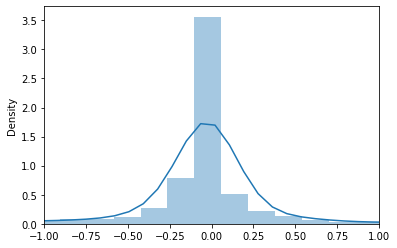

In [88]:
sns.distplot(y_test-pred,bins=100)
plt.xlim([-1,1])

In [89]:
from sklearn.metrics import mean_absolute_error
MAE=mean_absolute_error(y_test,pred)
print('MAE:',MAE)

MAE: 0.24153640790927278


In [92]:
# Pickle our model for deployment 
import pickle 
file=open('vrmodel.pkl','wb')
pickle.dump(final_model,file)

In [102]:
a=np.array([[2008,0,0,0,0,0,0,0,0,100,0,0,0,4.59,3.83]])
np.reshape(a,(1,-1))
final_model.predict(a)

array([0.03175454])

In [94]:
X_train[1]

array([2.00800000e+03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.58633626e-01, 3.82718146e-01])